# Time-Series Forecasting using CNN-RNN Hybrid Model 

# Weather Trends Forecaster: A CNN-RNN Hybrid Model

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Define the create_sequences function
def create_sequences(features, target, window_size=7):
    """
    Transforms the data into sequences for time-series forecasting.

    Parameters:
    - features (pd.DataFrame): Input feature data.
    - target (pd.Series): Target variable.
    - window_size (int): Number of time steps in each sequence.

    Returns:
    - np.array: Array of input sequences.
    - np.array: Array of corresponding target values.
    """
    x = []
    y = []
    for i in range(len(features) - window_size):
        x.append(features.iloc[i:i + window_size].values)  # Create sequences of features
        y.append(target.iloc[i + window_size])  # Target value for the sequence
    return np.array(x), np.array(y)

## 2. Loading the Dataset

In [3]:
df = pd.read_csv("weather_data_new.csv")

In [4]:
df.head()

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


## 3. Preprocessing the Dataset

In [5]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)


In [6]:
df.head()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
Date/Time,,,,,,,
2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [7]:
df.shape

(8784, 7)

In [8]:
df.isnull().sum()

Temp_C              0
Dew Point Temp_C    0
Rel Hum_%           0
Wind Speed_km/h     0
Visibility_km       0
Press_kPa           0
Weather             0
dtype: int64

In [9]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2012-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Temp_C            8784 non-null   float64
 1   Dew Point Temp_C  8784 non-null   float64
 2   Rel Hum_%         8784 non-null   int64  
 3   Wind Speed_km/h   8784 non-null   int64  
 4   Visibility_km     8784 non-null   float64
 5   Press_kPa         8784 non-null   float64
 6   Weather           8784 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 549.0+ KB


In [10]:
unique_values = df['Weather'].unique()
print(unique_values)

['Fog' 'Freezing Drizzle,Fog' 'Mostly Cloudy' 'Cloudy' 'Rain'
 'Rain Showers' 'Mainly Clear' 'Snow Showers' 'Snow' 'Clear'
 'Freezing Rain,Fog' 'Freezing Rain' 'Freezing Drizzle' 'Rain,Snow'
 'Moderate Snow' 'Freezing Drizzle,Snow' 'Freezing Rain,Snow Grains'
 'Snow,Blowing Snow' 'Freezing Fog' 'Haze' 'Rain,Fog' 'Drizzle,Fog'
 'Drizzle' 'Freezing Drizzle,Haze' 'Freezing Rain,Haze' 'Snow,Haze'
 'Snow,Fog' 'Snow,Ice Pellets' 'Rain,Haze' 'Thunderstorms,Rain'
 'Thunderstorms,Rain Showers' 'Thunderstorms,Heavy Rain Showers'
 'Thunderstorms,Rain Showers,Fog' 'Thunderstorms' 'Thunderstorms,Rain,Fog'
 'Thunderstorms,Moderate Rain Showers,Fog' 'Rain Showers,Fog'
 'Rain Showers,Snow Showers' 'Snow Pellets' 'Rain,Snow,Fog'
 'Moderate Rain,Fog' 'Freezing Rain,Ice Pellets,Fog'
 'Drizzle,Ice Pellets,Fog' 'Drizzle,Snow' 'Rain,Ice Pellets'
 'Drizzle,Snow,Fog' 'Rain,Snow Grains' 'Rain,Snow,Ice Pellets'
 'Snow Showers,Fog' 'Moderate Snow,Blowing Snow']


### Dropping The Weather Column

In [11]:
df = df.drop(columns=['Weather'])

In [12]:
df.head()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa
Date/Time,,,,,,
2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24
2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24
2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26
2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27
2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23


In [13]:
# Select relevant columns and handle missing values if necessary
df = df[['Temp_C', 'Dew Point Temp_C', 'Rel Hum_%', 'Wind Speed_km/h', 'Visibility_km', 'Press_kPa']]


### Standardizing numerical features

In [14]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [15]:
min_temp = df['Temp_C'].min()
max_temp = df['Temp_C'].max()
# Print the range
print(f"Temperature Range: {min_temp}°C to {max_temp}°C")

Temperature Range: -23.3°C to 33.0°C


In [16]:
min_temp = df['Dew Point Temp_C'].min()
max_temp = df['Dew Point Temp_C'].max()
# Print the range
print(f"Dew Point Temp_C Range: {min_temp}°C to {max_temp}°C")

Dew Point Temp_C Range: -28.5°C to 24.4°C


In [23]:
min_hum = df['Rel Hum_%'].min()
max_hum = df['Rel Hum_%'].max()
# Print the range
print(f"Rel Hum_% Range: {min_hum}% to {max_hum}%")


Rel Hum_% Range: 18% to 100%


In [24]:
min_speed = df['Wind Speed_km/h'].min()
max_speed = df['Wind Speed_km/h'].max()
# Print the range
print(f"Wind Speed_km/h Range: {min_speed}km/h to {max_speed}km/hr")


Wind Speed_km/h Range: 0km/h to 83km/hr


In [25]:
min_vis = df['Visibility_km'].min()
max_vis = df['Visibility_km'].max()
# Print the range
print(f"Visibility_km Range: {min_vis}km to {max_vis}km")


Visibility_km Range: 0.2km to 48.3km


In [26]:
min_pre = df['Press_kPa'].min()
max_pre = df['Press_kPa'].max()
# Print the range
print(f"Press_kPa Range: {min_pre}kPa to {max_pre}kPa")


Press_kPa Range: 97.52kPa to 103.65kPa


### Checking for Outliers in Temperature

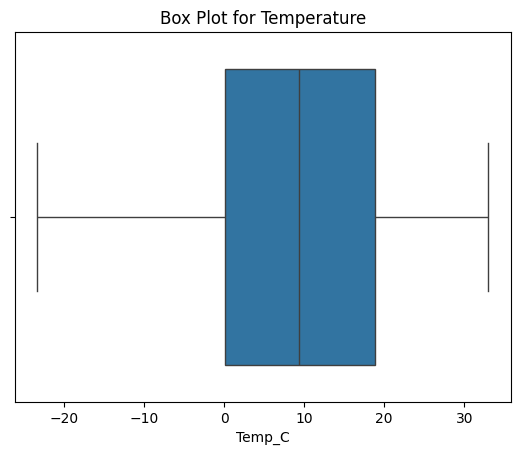

In [18]:
sns.boxplot(x=df['Temp_C'])
plt.title('Box Plot for Temperature')
plt.show()

In [19]:
# Prepare features (X) and target (y)
features = pd.DataFrame(scaled_data, columns=df.columns)  # Scaled features
target = df['Temp_C']  # Target variable

### Create sequences for time-series forecasting

In [20]:
window_size = 14  # Define the time window size
X, y = create_sequences(features, target, window_size=window_size)


## 4. Splitting into Train and Test

In [21]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [22]:
# Convert data to np.float32 for TensorFlow compatibility
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

## 5. Building the Model

In [24]:
# Define the CNN-RNN hybrid model
model = Sequential()

# CNN layers for feature extraction
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal', dilation_rate=2, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal', dilation_rate=2))

model.add(Dropout(0.4))
model.add(BatchNormalization())

# Additional CNN layer for enhanced feature extraction
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal', dilation_rate=2))

model.add(Dropout(0.4))
model.add(BatchNormalization())

# RNN layer for sequential dependencies
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(1))

### Compiling the Model

In [25]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [26]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, min_delta=0.0001, verbose=1)


## 6. Training the Model

In [27]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 100.4063 - mae: 7.5658 - val_loss: 16.0657 - val_mae: 3.2308
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 14.7557 - mae: 3.0227 - val_loss: 7.8113 - val_mae: 2.1590
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 12.5054 - mae: 2.7863 - val_loss: 5.6538 - val_mae: 1.8485
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 10.5707 - mae: 2.5443 - val_loss: 6.5667 - val_mae: 2.0001
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 10.4140 - mae: 2.5472 - val_loss: 5.7994 - val_mae: 1.9047
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 9.4042 - mae: 2.4343 - val_loss: 5.4637 - val_mae: 1.9116
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.7602 - mae: 2.3168 - val_loss: 4.1122 - val_mae: 1.5030
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.3151 - mae: 2.2750 - val_loss: 9.3382 - val_mae: 2.4968
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12

## 7. Model Evaluation

In [28]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5097 - mae: 1.2312
Test Loss: 2.5706005096435547
Test MAE: 1.264944314956665


### Making Predictions

In [29]:
# Make predictions
y_pred = model.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [30]:
# Inverse scaling of predictions
y_pred_reshaped = np.zeros((y_pred.shape[0], features.shape[1]))  # Placeholder with the same number of columns as features
y_pred_reshaped[:, 0] = y_pred.reshape(-1)  # Put the predicted values in the first column
y_pred_original = scaler.inverse_transform(y_pred_reshaped)[:, 0]  # Inverse transform to get the original scale

# Inverse scaling of actual test labels
y_test_reshaped = np.zeros((y_test.shape[0], features.shape[1]))  # Same for the actual test labels
y_test_reshaped[:, 0] = y_test.reshape(-1)
y_test_original = scaler.inverse_transform(y_test_reshaped)[:, 0]


## 8. Assessing the model performance using RMSE (Root Mean Squared Error)

In [31]:
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"Test RMSE: {rmse}")

Test RMSE: 18.7382233914037


## 9.Visualization

## Actual vs Predicted using Line Plot

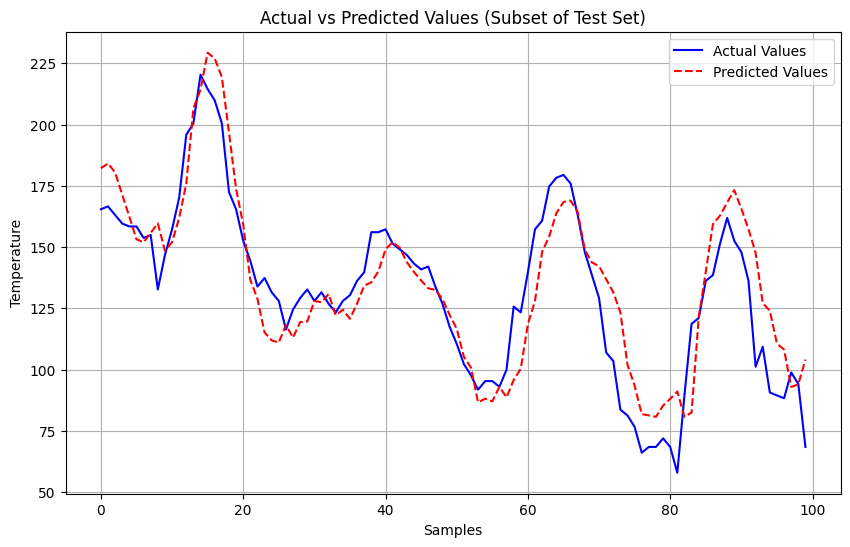

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label='Actual Values', color='blue')
plt.plot(y_pred_original[:100], label='Predicted Values', color='red', linestyle='--')
plt.title('Actual vs Predicted Values (Subset of Test Set)')
plt.xlabel('Samples')
plt.ylabel('Temperature')
plt.grid()
plt.legend()
plt.show()

## Training & Validation Loss using Line Plot

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


### Saving the Preprocessed Dataset

In [212]:
df.to_csv('preprocessed_dataset.csv', index=False)

print("Dataset saved as 'preprocessed_dataset.csv'")

Dataset saved as 'preprocessed_dataset.csv'
